## Packages 


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import glob
import nibabel as nib
from skimage.io import imsave
from skimage.transform import resize
from sklearn.preprocessing import normalize
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
from keras.callbacks import  ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade tensorflow
!pip install segmentation_models
import segmentation_models as sm

!pip install "tensorflow_hub>=0.6.0"
import tensorflow_hub as tfhub

!python -m pip install -U efficientnet



In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Download The Data 

In [0]:

#Download the dataset
!wget https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
!wget https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1

# Rename the zip files to images and masks, it will be save in the content colab directory 
!mv COVID-19-CT-Seg_20cases.zip?download=1 images.zip
!mv Lung_and_Infection_Mask.zip?download=1 masks.zip

# Extract the two zip files to its nifti files
!unzip -uq "images.zip" -d "images"
!unzip -uq "masks.zip" -d "masks"


# Create temporal Directory 'DataSet' to save the images(png) and masks(png) in google server   
!mkdir DataSet
!mkdir DataSet/images 
!mkdir DataSet/masks


## Load & Preprocess Data

In [0]:
#=================================================================
# Copy DataLoader.py file to temporary colab server to be able to import it 
! cp "drive/My Drive/Project/DataLoader.py" '.'
! cp "drive/My Drive/Project/function.py" '.'
! cp "drive/My Drive/Project/DenseModel.py" '.'




#Import files, Dataloader, DenseModel, function 
from importlib import reload
import DataLoader as ld
from function import *
import DenseModel 
ld = reload(ld)
DenseModel= reload(DenseModel)
#function = reload(function)




In [0]:

# call nifToPng function which extract all the nifti files for images and masks and
# apply preprocessing then save them in DataSet in the temporal google servers 
ld.nifToPng('images','masks');

## Copy Data To Drive.
Data originaly is saved to temporal colab server not drive. 
then by running this code we copy it to drive to store it permenantly, run this process the first time you use the program then start moving it to colab whenever you need it  

In [0]:
# Do this if there is no data in drive 
#!mkdir 'drive/My Drive/Project/DataSet'
# !cp -r 'DataSet/' 'drive/My Drive/Project'

# check number of images and masks  in colab and drive 
print(len(os.listdir('drive/My Drive/Project/DataSet/images')))
print(len(os.listdir('drive/My Drive/Project/DataSet/masks')))
print(len(os.listdir('DataSet/masks')))
print(len(os.listdir('DataSet/images')))


3519
3520


FileNotFoundError: ignored

## Copy Data From Drive to Temporal colab google server. 
do this step if the temporal session of colab ends and the data is deleted

In [0]:
# when the session ends, all the data on colab server will be deleted. So we get the data from
# the saved dataset in colab.  
# To Copy data from drive to colab it takes som much time so  zip the folder in drive then copy it
# to colab then unzip it 

!cp -r 'drive/My Drive/Project/Dataset.zip' '.'
# unzip the file, change the file name to whatever the zip file name
!unzip -uq "Dataset.zip" -d '.'




## **Train, Test, Validation** 

In [0]:
# Call the splitData function which works on the 
# temporal google server where it is faster 
#! cp "drive/My Drive/Project/DataLoader.py" '.'
X_train, X_tset, Y_train, Y_test, X_, X_val, Y_, Y_val,X = ld.splitData()

##**Fully convolutional multi-scale residual DenseNets**

In [0]:
# Input & output 
IMG_Width  = 128
IMG_Height = 128
IMG_Channels = 1


input=tf.keras.Input((IMG_Width,IMG_Height,IMG_Channels)) # this layer is in core layer of keras documentation
model= DenseModel.dens_model(input)



In [0]:
# Fit the Dense Model 
Callbacks=[tf.keras.callbacks.ModelCheckpoint("drive/My Drive/Project/dens.h5"
,verbose=1,save_best_only=True)]
 
history = model.fit(
   x=X_train,
   y=Y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_val, Y_val)
)
 
model.save('drive/My Drive/Project/FinalDense.h5')
 
np.save('drive/My Drive/Project/historyFinalDense.npy',history.history)


## **Build Pretrained Models**

In [0]:
# Copy Model.py file from drive to colab server 
! cp "drive/My Drive/Project/Model.py" '.'

# Import the Model file , we added the reload package to update the changes auto from drive to colab 
from importlib import reload
import Model as mdl
mdl = reload(mdl)

# Buid network, X is the input tensor
mdl.Network(X)




In [0]:
# Fit The pretrained model
history, model = mdl.Fit(X_train, Y_train, X_val, Y_val)


## **Load an existing model & history**
Do this step if you have existing model

In [0]:

# Load PreTrainedModels
#========================================================================================
# Inception Net v2 , Dice loss, IOU metrices
inceptionModel = tf.keras.models.load_model('drive/My Drive/Project/Models/inceptionresnetv2.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

inceptionModel.compile(
    optim,
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)   
historyinceptionModel = np.load("drive/My Drive/Project/Models/historyinceptionresnetv2.npy",allow_pickle=True).item()
#==============================================================================================
# Basic uNet , Dice loss, IOU metrices
basicUNETModel = tf.keras.models.load_model('drive/My Drive/Project/Models/u_net_basic1.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

model.compile(
    optim,
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)   
historybasicUNETModel = np.load("drive/My Drive/Project/Models/historyinceptionresnetv2.npy",allow_pickle=True).item()
#==============================================================================================
# Mobile Net , Dice loss, IOU metrices
mobileModel = tf.keras.models.load_model('drive/My Drive/Project/Models/mobilenetv2.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

mobileModel.compile(
    optim,
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)   
historymobileModel = np.load("drive/My Drive/Project/Models/historymobilenetv2.npy",allow_pickle=True).item()
#================================================================================================

#====================================Main Dense Model===========================================

# Load Final Dense model, Trained with CategoricalCrossentropy loss and Dice coef metrices , optimised with Adam
model = tf.keras.models.load_model('drive/My Drive/Project/Models/FinalDense.h5',compile=False)
optim = keras.optimizers.Adam(lr=1e-3)

loss= tf.keras.losses.CategoricalCrossentropy(
      from_logits=False,
      label_smoothing=0,
      reduction="auto",
      name="categorical_crossentropy",
  )

model.compile(optim,loss=loss ,metrics=[sm.metrics.f1_score])

model.summary()

#History
history = np.load("drive/My Drive/Project/Models/historyFinalDense.npy",allow_pickle=True).item()

## **Metrices**


In [0]:

! cp "drive/My Drive/Project/Metrices.py" '.'

from importlib import reload
import Metrices as met
met = reload(met)
print(history )
# Plot Accuracy & Loss DICE(F1 score) 
met.showLossAccu(history)



## **Prediction & Metrices & Plots**

In [0]:
#========================= Evaluate ==============================================
scoreDense =model.evaluate(X_tset,Y_test,batch_size=26)
scoreMobile =mobileModel.evaluate(X_tset,Y_test,batch_size=26)
scoreInception =inceptionModel.evaluate(X_tset,Y_test,batch_size=26)

#=======================Find predections==========================================
predDense= model.predict(X_tset)
predMobile= mobileModel.predict(X_tset)
predInception= inceptionModel.predict(X_tset)

# merge the labels in last axis, test and predict from dense model 
pred_merge = np.argmax(predDense, axis = 3)
test = np.argmax(Y_test, axis = 3)




In [193]:
# ======================= Metrices & Statistics====================================

# Dice Cof for mobile & Inception. ?? Ask difference between calling dice in compile and in standalone function 
cofMobile = met.dice_coef(Y_test,predMobile)
cofInception = met.dice_coef(Y_test,predInception)

# Jaccard(IOU), for Dense model ??
iouDense = met.jc(Y_test,predDense)
iouMobile = met.jc(Y_test,predInception)

# Hausdorff Distance ??
hdDense = met.Hausdorff(Y_test,predDense)
hdMobile = met.Hausdorff(Y_test,predMobile)
hdInception = met.Hausdorff(Y_test,predInception)


# Pearsona & P-value, returns null ?????
pDense = met.pearsonr_Corr(Y_test,predDense)

# ................ Table Parameters..............................................

# Import pandas library 
import pandas as pd 
  
data = {'Dice':[scoreDense[1]*100,cofMobile*100,cofInception*100],
        'IOU':[iouDense*100,scoreMobile[1]*100,scoreInception[1]*100],
        'HD':[hdDense, hdMobile, hdInception],
        'Pearsona':[pDense[0], pMobile[0], pIncep[0]], 
        'P-value':[pDense[1], pMobile[1], pIncep[1]],
        'LR':[0.001, 0.00001, 0.001],
        'Optimizer':['Adam', 'Adam', 'Adam'],
        'Param':[model.count_params(),mobileModel.count_params(), inceptionModel.count_params() ]} 
# Create the pandas DataFrame 
df = pd.DataFrame(data,index =['DenseM', 'Mobile', 'Inception']) 
  
# print dataframe. 
df 


,Dice,IOU,HD,Pearsona,P-value,LR,Optimizer,Param
DenseM,89.947277,25.045190,3.0,NaN,NaN,0.00100,Adam,880500
Mobile,40.000000,84.967762,3.0,NaN,NaN,0.00001,Adam,8047882
Inception,39.995853,58.105737,3.0,NaN,NaN,0.00100,Adam,62061994


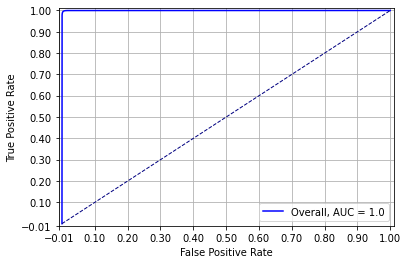

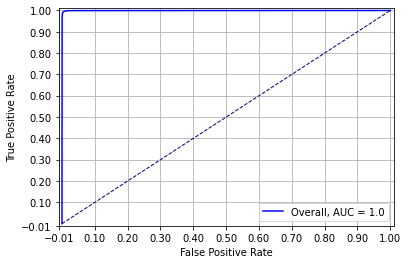

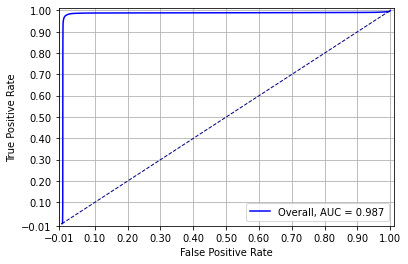

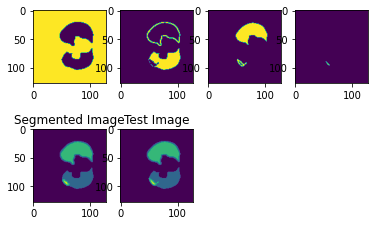

In [197]:

#........................ ROC Plots ..............................................
met.ROC(Y_test.ravel(), predDense.ravel())
met.ROC(Y_test.ravel(), predMobile.ravel())
met.ROC(Y_test.ravel(), predInception.ravel())



#==========================================

plt.subplot('241')
plt.imshow(Y_test[60,:,:,0])
plt.subplot('242')
plt.imshow(Y_test[60,:,:,1])
plt.subplot('243')
plt.imshow(Y_test[60,:,:,2])
plt.subplot('244')
plt.imshow(Y_test[60,:,:,3])
plt.subplot('245')
plt.title('Segmented Image')
plt.imshow(pred_merge[60])
plt.subplot('246')
plt.title('Test Image')
plt.imshow(test[60])
